## 《合成孔径雷达成像——算法与实现》中6.3.2 距离多普勒算法之距离压缩

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体 
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

from numpy import pi,abs,max,min,argmax,argmin,ceil,exp,sqrt,real,imag,conj,sinc,sin,cos,tan,arctan,log10,angle,unwrap
from numpy import linspace,arange,zeros,ones,concatenate,convolve
from numpy.fft import fft,fftshift,ifft,ifftshift,fft2
from matplotlib.pyplot import figure,subplot,plot,axis,title,suptitle,xlabel,ylabel,text,arrow,tight_layout

In [2]:
## 参数设置
#  已知参数--》距离向参数
R_eta_c = 20e+3;                # 景中心斜距
Tr = 2.5e-6;                    # 发射脉冲时宽
Kr = 20e+12;                    # 距离向调频率
alpha_os_r = 1.2;               # 距离过采样率
Nrg = 320;                      # 距离线采样点数
#  计算参数--》距离向参数
Bw = abs(Kr)*Tr;                # 距离信号带宽
Fr = alpha_os_r*Bw;             # 距离向采样率
Nr = np.round(Fr*Tr);              # 距离采样点数(脉冲序列长度)
#  已知参数--》方位向参数
c = 3e+8;                       # 电磁传播速度
Vr = 150;                       # 等效雷达速度
Vs = Vr;                        # 卫星平台速度
Vg = Vr;                        # 波束扫描速度
f0 = 5.3e+9;                    # 雷达工作频率
Delta_f_dop = 80;               # 多普勒带宽
alpha_os_a = 1.25;              # 方位过采样率
Naz = 256;                      # 距离线数
theta_r_c = +3.5*pi/180;        # 波束斜视角
#  计算参数--》方位向参数
lambda0 = c/f0;                  # 雷达工作波长
t_eta_c = -R_eta_c*sin(theta_r_c)/Vr;
                                # 波束中心穿越时刻
f_eta_c = 2*Vr*sin(theta_r_c)/lambda0;
                                # 多普勒中心频率
La = 0.886*2*Vs*cos(theta_r_c)/Delta_f_dop;               
                                # 实际天线长度
Fa = alpha_os_a*Delta_f_dop;    # 方位向采样率
Ta = 0.886*lambda0*R_eta_c/(La*Vg*cos(theta_r_c));
                                # 目标照射时间
R0 = R_eta_c*cos(theta_r_c);    # 最短斜距
Ka = 2*Vr**2*cos(theta_r_c)**2/lambda0/R0;              
                                # 方位向调频率
theta_bw = 0.886*lambda0/La;     # 方位向3dB波束宽度
theta_syn = Vs/Vg*theta_bw;     # 合成角宽度
Ls = R_eta_c*theta_syn;         # 合成孔径长度
#  参数计算
rho_r = c/(2*Fr);               # 距离向分辨率
rho_a = La/2;                   # 距离向分辨率
Trg = Nrg/Fr;                   # 发射脉冲时宽
Taz = Naz/Fa;                   # 目标照射时间
d_t_tau = 1/Fr;                 # 距离采样时间间隔
d_t_eta = 1/Fa;                 # 方位采样时间间隔
d_f_tau = Fr/Nrg;               # 距离采样频率间隔    
d_f_eta = Fa/Naz;               # 方位采样频率间隔
## 目标设置
#  设置目标点相对于景中心之间的距离
A_r =   0; A_a =   0;                                   # A点位置
B_r = -50; B_a = -50;                                   # B点位置
C_r = -50; C_a = +50;                                   # C点位置
D_r = +50; D_a = C_a + (D_r-C_r)*tan(theta_r_c);        # D点位置
#  得到目标点相对于景中心的位置坐标
A_x = R0 + A_r; A_Y = A_a;                              # A点坐标
B_x = R0 + B_r; B_Y = B_a;                              # B点坐标
C_x = R0 + C_r; C_Y = C_a;                              # C点坐标
D_x = R0 + D_r; D_Y = D_a;                              # D点坐标
NPosition = np.array([[A_x,A_Y],
             [B_x,B_Y],
             [C_x,C_Y],
             [D_x,D_Y]      ])                          # 设置数组
# fprintf( 'A点坐标为[#+3.3f，#+3.3f]km\n', NPosition(1,1)/1e3, NPosition(1,2)/1e3 );
# fprintf( 'B点坐标为[#+3.3f，#+3.3f]km\n', NPosition(2,1)/1e3, NPosition(2,2)/1e3 );
# fprintf( 'C点坐标为[#+3.3f，#+3.3f]km\n', NPosition(3,1)/1e3, NPosition(3,2)/1e3 );
# fprintf( 'D点坐标为[#+3.3f，#+3.3f]km\n', NPosition(4,1)/1e3, NPosition(4,2)/1e3 );
#  得到目标点的波束中心穿越时刻
Ntarget = 4;
Tar_t_eta_c = zeros(Ntarget);
for i in range( Ntarget ):
    DeltaX = NPosition[i][1] - NPosition[i][0]*tan(theta_r_c);
    Tar_t_eta_c[i] = DeltaX/Vs;

#  得到目标点的绝对零多普勒时刻
Tar_t_eta_0 = zeros(Ntarget);
for i in range( Ntarget ):
    Tar_t_eta_0[i] = NPosition[i][1]/Vr;

## 变量设置
#  时间变量 以景中心的零多普勒时刻作为方位向零点
t_tau = arange(-Trg/2,Trg/2,d_t_tau) + 2*R_eta_c/c;   # 距离时间变量
t_eta = arange(-Taz/2,Taz/2,d_t_eta) + t_eta_c;       # 方位时间变量
#  长度变量
r_tau = (t_tau*c/2)*cos(theta_r_c);                     # 距离长度变量
#  频率变量 
f_tau = fftshift(arange(-Fr/2,Fr/2,d_f_tau));           # 距离频率变量
f_tau = f_tau - np.round((f_tau-0)/Fr)*Fr;                 # 距离频率变量(可观测频率)  
f_eta = fftshift(arange(-Fa/2,Fa/2,d_f_eta));           # 方位频率变量
f_eta = f_eta - np.round((f_eta-f_eta_c)/Fa)*Fa;           # 方位频率变量(可观测频率)
## 坐标设置     
#  以距离时间为X轴，方位时间为Y轴
t_tauX,t_etaY = np.meshgrid(t_tau,t_eta);                # 设置距离时域-方位时域二维网络坐标
#  以距离长度为X轴，方位频率为Y轴                                                                                                            
r_tauX,f_etaY = np.meshgrid(r_tau,f_eta);                # 设置距离时域-方位频域二维网络坐标
#  以距离频率为X轴，方位频率为Y轴                                                                                                            
f_tau_X,f_eta_Y = np.meshgrid(f_tau,f_eta);              # 设置频率时域-方位频域二维网络坐标
## 信号设置--》原始回波信号                                                        

In [3]:
from tqdm import trange
bar = trange(Ntarget)
st_tt = zeros((Naz,Nrg));
import time
for i in bar:
    #  计算目标点的瞬时斜距
    R_eta = sqrt( NPosition[i][0]**2 + Vr**2*(t_etaY-Tar_t_eta_0[i])**2 ); 
    #{
#     R_eta = NPosition[i][0] + Vr**2*t_etaY**2/(2*NPosition[i][0]);   
    #}
    #  后向散射系数幅度
    A0 = ones(4)*exp(+1j*0);   
    #  距离向包络
    wr = np.where(abs(t_tauX-2*R_eta/c) <= Tr/2,1,0);                               
    #  方位向包络
    wa = sinc(0.886*arctan(Vg*(t_etaY-Tar_t_eta_c[i])/NPosition[i][0])/theta_bw)**2;      
    #  接收信号叠加
    st_tt_tar = A0[i]*wr*wa*exp(-1j*4*pi*f0*R_eta/c)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2); 
    #{
#     st_tt_tar = A0[i]*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2);
    #}                                                          
    st_tt = st_tt + st_tt_tar;  
    
    time.sleep(0.1);
    bar.set_description( ''+ str( np.round(i/Ntarget*100) ) )
## 绘图

75.0: 100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


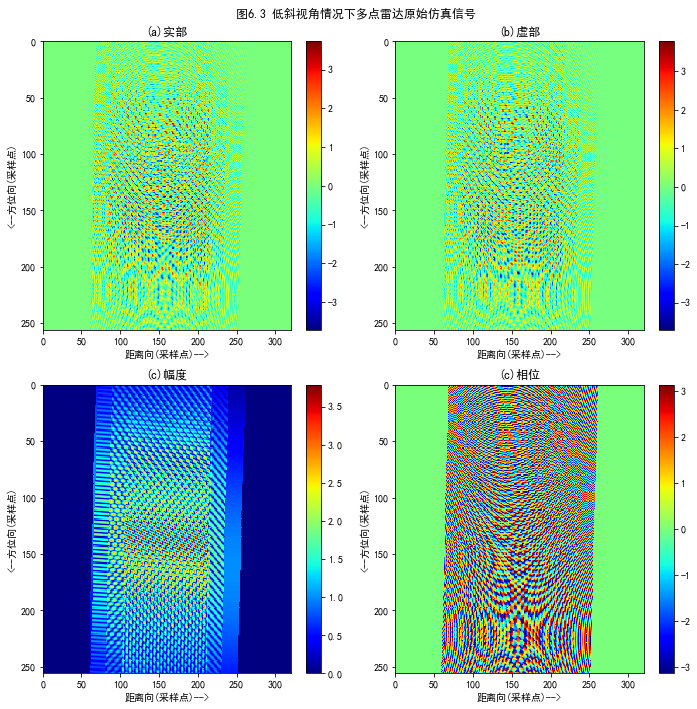

In [5]:
# np.savetxt('6_3_st_tt.txt',st_tt)
H = figure(figsize=(10,10));
subplot(221),plt.pcolor( real(st_tt),cmap='jet')     
plt.colorbar(shrink = 1.0)
xlabel('距离向(采样点)-->'),ylabel('<--方位向(采样点)'),title('(a)实部');
plt.gca().invert_yaxis()
subplot(222),plt.pcolor( imag(st_tt),cmap='jet')
plt.colorbar(shrink = 1.0)
xlabel('距离向(采样点)-->'),ylabel('<--方位向(采样点)'),title('(b)虚部');
plt.gca().invert_yaxis()
subplot(223),plt.pcolor(  abs(st_tt),cmap='jet') 
plt.colorbar(shrink = 1.0)
xlabel('距离向(采样点)-->'),ylabel('<--方位向(采样点)'),title('(c)幅度');
plt.gca().invert_yaxis()
subplot(224),plt.pcolor(angle(st_tt),cmap='jet')
plt.colorbar(shrink = 1.0)
xlabel('距离向(采样点)-->'),ylabel('<--方位向(采样点)'),title('(c)相位');
plt.gca().invert_yaxis()
suptitle('图6.3 低斜视角情况下多点雷达原始仿真信号')
plt.tight_layout()

本文Python代码参照Matlab代码自：https://github.com/wanghs008/SAR-SignalProcessing